## Import Libraries

In [81]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

## Load the Data

In [82]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [83]:
df.shape

(5624, 11)

In [84]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [85]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [86]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [87]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [88]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [89]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

In [90]:
df = df[df['Year']>=2000]

In [91]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 5].index)]

In [92]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=5].index)]

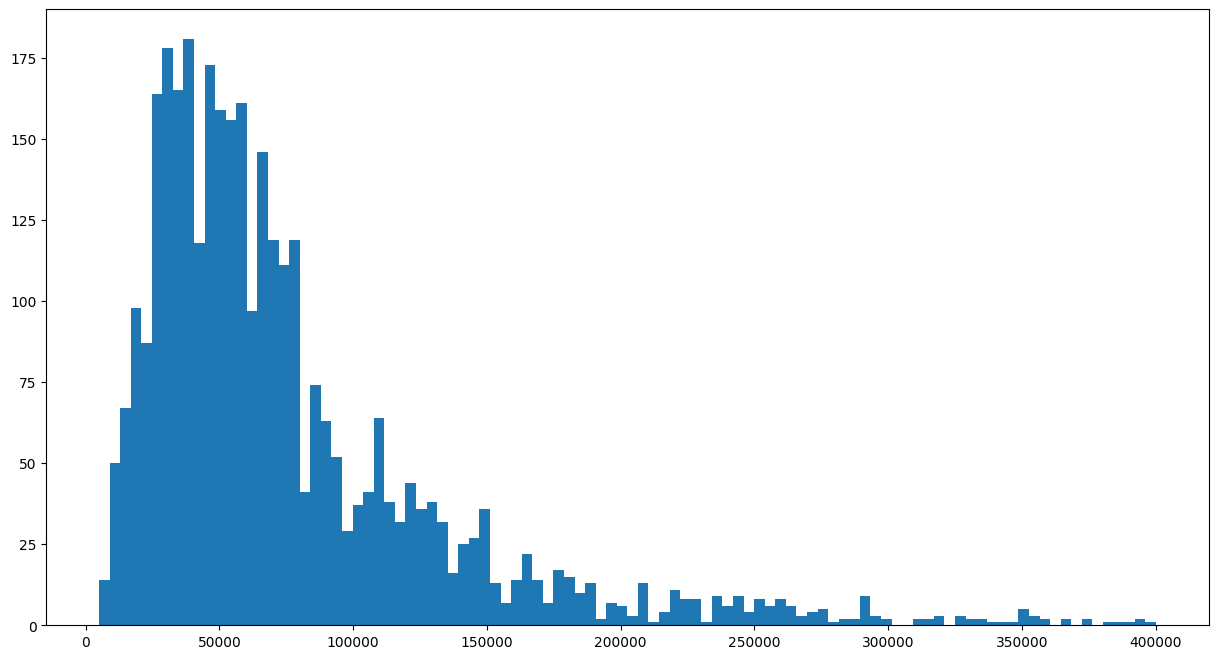

In [93]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [94]:
df = df[(df['Price']<=400000) & (df['Price']>=5000)]

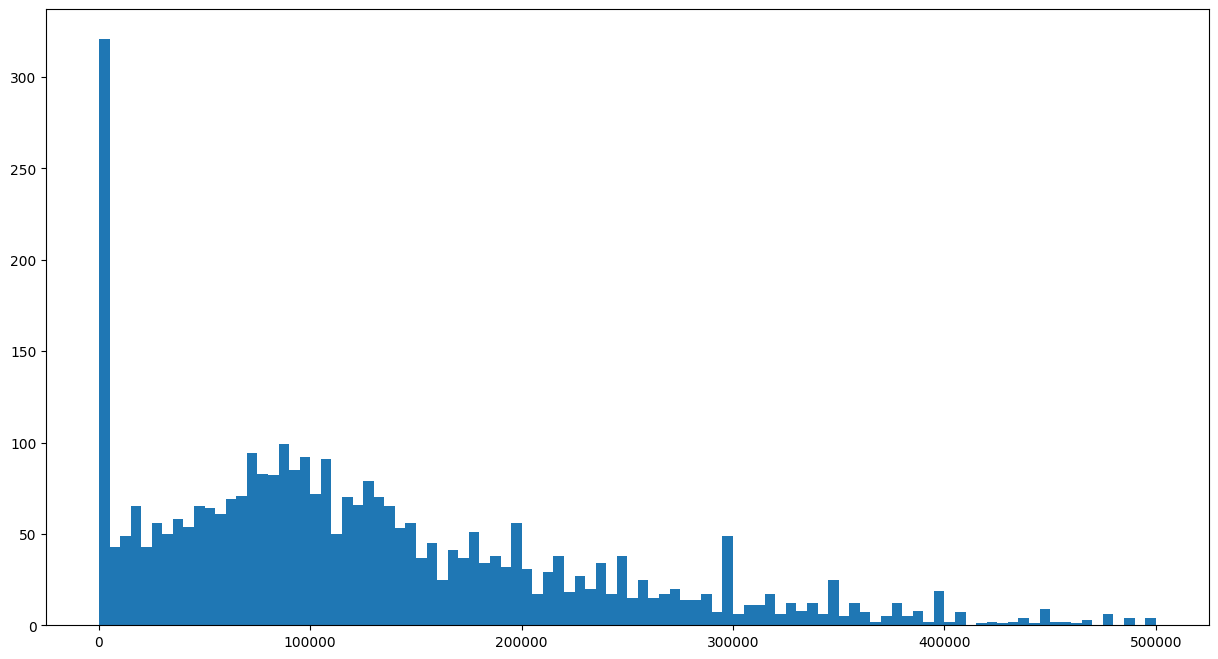

In [95]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=500000]['Mileage'], bins=100);

In [96]:
df = df[df['Mileage']<=500000]
df.shape

(3376, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [97]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

#### 3. Feature selection

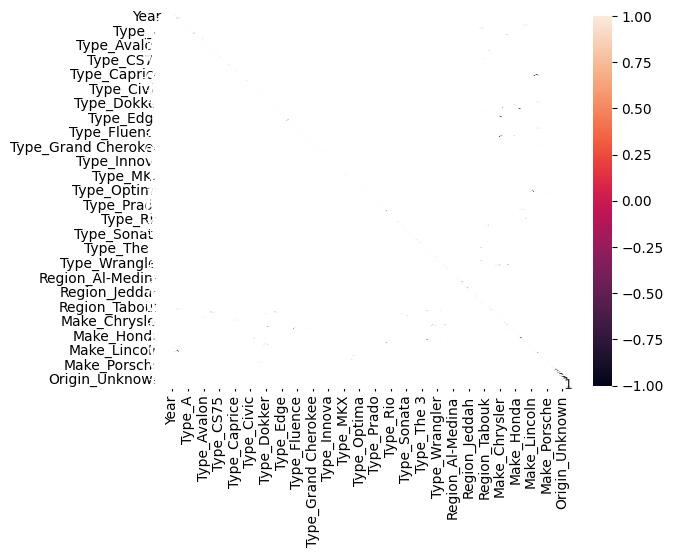

In [98]:
#sns.heatmap(df.corr(), annot=True);

In [99]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
Year                0.389073
Options_Full        0.342477
Engine_Size         0.317764
Make_Mercedes       0.300105
                      ...   
Origin_Saudi       -0.177830
Make_Hyundai       -0.209379
Options_Standard   -0.281469
Mileage            -0.307947
Negotiable               NaN
Name: Price, Length: 229, dtype: float64


In [100]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index

In [101]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Price,Type_LX,Type_Land Cruiser,Type_Range Rover,Type_S,Make_Hyundai,Make_Land Rover,Make_Lexus,Make_Mercedes,Options_Full,Options_Standard
1,2014,8.0,80000,120000,False,False,False,False,False,False,False,False,True,False
2,2015,5.0,140000,260000,False,False,True,False,False,True,False,False,True,False
3,2015,2.4,220000,42000,False,False,False,False,False,False,False,False,False,False
5,2019,2.0,25000,58000,False,False,False,False,False,False,False,False,False,False
7,2016,2.4,155,48000,False,False,False,False,True,False,False,False,True,False


#### 4. Prepare train and test data

In [113]:
# Prepare data
X = df.drop(['Price'], axis=1)
y = df['Price']

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,shuffle=True, random_state=42)

## Buliding the Model

In [114]:
model = LinearRegression()

## Train the Model

In [115]:
# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

## Test the Model

In [116]:
# Predict and evaluate the model
y_pred = model.predict(X_test)

## Interpretation of the Model

In [124]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df # To see how the price will be affected when we make all fixed and increase one of Coefficient

,Coefficient
Year,3.093373e+04
Engine_Size,1.911194e+04
Mileage,-5.101691e+03
Type_LX,6.393063e+03
Type_Land Cruiser,1.470182e+04
Type_Range Rover,-2.344598e+17
Type_S,4.701607e+03
Make_Hyundai,-5.893387e+03
Make_Land Rover,2.344598e+17
Make_Lexus,1.043736e+04


In [126]:
print(model.intercept_) 

76753.7433515411


## Evaluating the Model 

In [117]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1164895423.6320953


#### Predictions vs. Real Values

In [129]:
predictions = model.predict(X_test)
#predictions

In [130]:
Real_Values = np.array(y_test)
#Real_Values

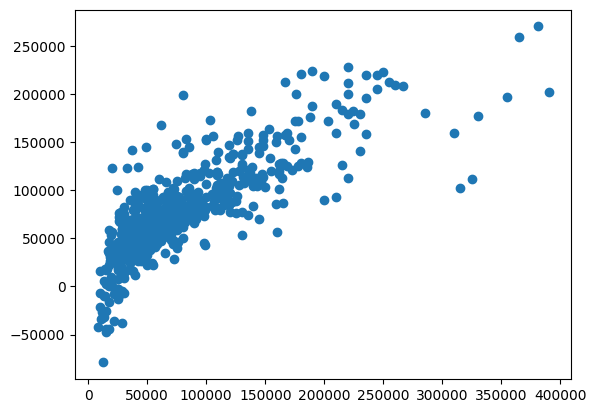

In [131]:
plt.scatter(Real_Values,predictions); # it's good if we get positive relationship

#### Residual Histogram

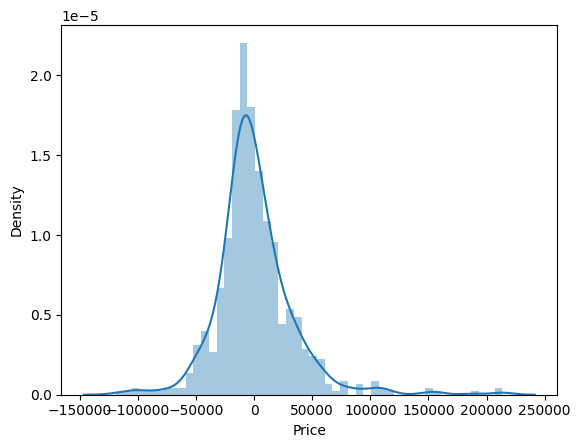

In [132]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [24]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 82288.22251914954
MSE: 10460958907.209501
RMSE: 102278.82922291153
